/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv



In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Setup path
TRAIN_PATH = '/kaggle/input/titanic/train.csv'
TEST_PATH = '/kaggle/input/titanic/test.csv'
OUTPUT_PATH = '/kaggle/working/gender_submission.csv'
print(os.listdir('/kaggle/input/titanic'))

['train.csv', 'test.csv', 'gender_submission.csv']


In [2]:
# Visualize data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
print("Train data:")
print(train_df.head())
print('\n\n')
print("Test data:")
print(test_df.head())

Train data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

In [3]:
# Preprocess data

# Get target variable
y = train_df['Survived']

X = train_df
X_test = test_df

# Fill missing values
X['Age'] = X['Age'].fillna(X['Age'].mean())
X['Fare'] = X['Fare'].fillna(X['Fare'].mean())
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())

# Create pertinent features
# Family size
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
# IsAlone
X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
X_test['IsAlone'] = (X_test['FamilySize'] == 1).astype(int)
# Age group
X['AgeGroup'] = pd.cut(X['Age'], bins=[0, 12, 21, 65, 200], labels=['Childrens', 'Adolescents', 'Adults', 'Seniors'])
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=[0, 12, 18, 65, 200], labels=['Childrens', 'Adolescents', 'Adults', 'Seniors'])
# Fare group
X['FareGroup'] = pd.cut(X['Fare'], bins=[-1, 6, 12, 29, 870, 10000], labels=['Low_fare', 'Medium_fare', 'High_fare', 'Very_high_fare', 'Ultra_high_fare'])
X_test['FareGroup'] = pd.cut(X_test['Fare'], bins=[-1, 6, 12, 29, 870, 10000], labels=['Low_fare', 'Medium_fare', 'High_fare', 'Very_high_fare', 'Ultra_high_fare'])
# Title
X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X['Title'] = X['Title'].replace('Mlle', 'Miss')
X['Title'] = X['Title'].replace('Ms', 'Miss')
X['Title'] = X['Title'].replace('Mme', 'Mrs')
X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['Title'] = X_test['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X_test['Title'] = X_test['Title'].replace('Mlle', 'Miss')
X_test['Title'] = X_test['Title'].replace('Ms', 'Miss')
X_test['Title'] = X_test['Title'].replace('Mme', 'Mrs')

# Get rid of unnecessary columns
X = X.drop(['Age', 'Fare', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 
X_test = X_test.drop(['Age', 'Fare', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

print(X.head())

   Survived  Pclass     Sex  SibSp  Parch Embarked  FamilySize  IsAlone  \
0         0       3    male      1      0        S           2        0   
1         1       1  female      1      0        C           2        0   
2         1       3  female      0      0        S           1        1   
3         1       1  female      1      0        S           2        0   
4         0       3    male      0      0        S           1        1   

  AgeGroup       FareGroup Title  
0   Adults     Medium_fare    Mr  
1   Adults  Very_high_fare   Mrs  
2   Adults     Medium_fare  Miss  
3   Adults  Very_high_fare   Mrs  
4   Adults     Medium_fare    Mr  


In [4]:
# One-hot encode categorical variables
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

# Make sure there are no missing values and all values are numerical
print("Train data:")
print(X.info())
print('\n\n')
print("Test data:")
print(X_test.info())

# Make sure there are no empty / NaN values
print("Train data:")
print(X.isnull().sum())
print('\n\n')
print("Test data:")
print(X_test.isnull().sum())

# Make sure there are no empty / NaN values
print("Train data:")
print(X.head())

# Number of features
input_dim = X.shape[1]
print("Input dimensions: %s" % (input_dim))

Train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Survived                   891 non-null    int64
 1   Pclass                     891 non-null    int64
 2   SibSp                      891 non-null    int64
 3   Parch                      891 non-null    int64
 4   FamilySize                 891 non-null    int64
 5   IsAlone                    891 non-null    int64
 6   Sex_female                 891 non-null    bool 
 7   Sex_male                   891 non-null    bool 
 8   Embarked_C                 891 non-null    bool 
 9   Embarked_Q                 891 non-null    bool 
 10  Embarked_S                 891 non-null    bool 
 11  AgeGroup_Childrens         891 non-null    bool 
 12  AgeGroup_Adolescents       891 non-null    bool 
 13  AgeGroup_Adults            891 non-null    bool 
 14  AgeGroup_Senio

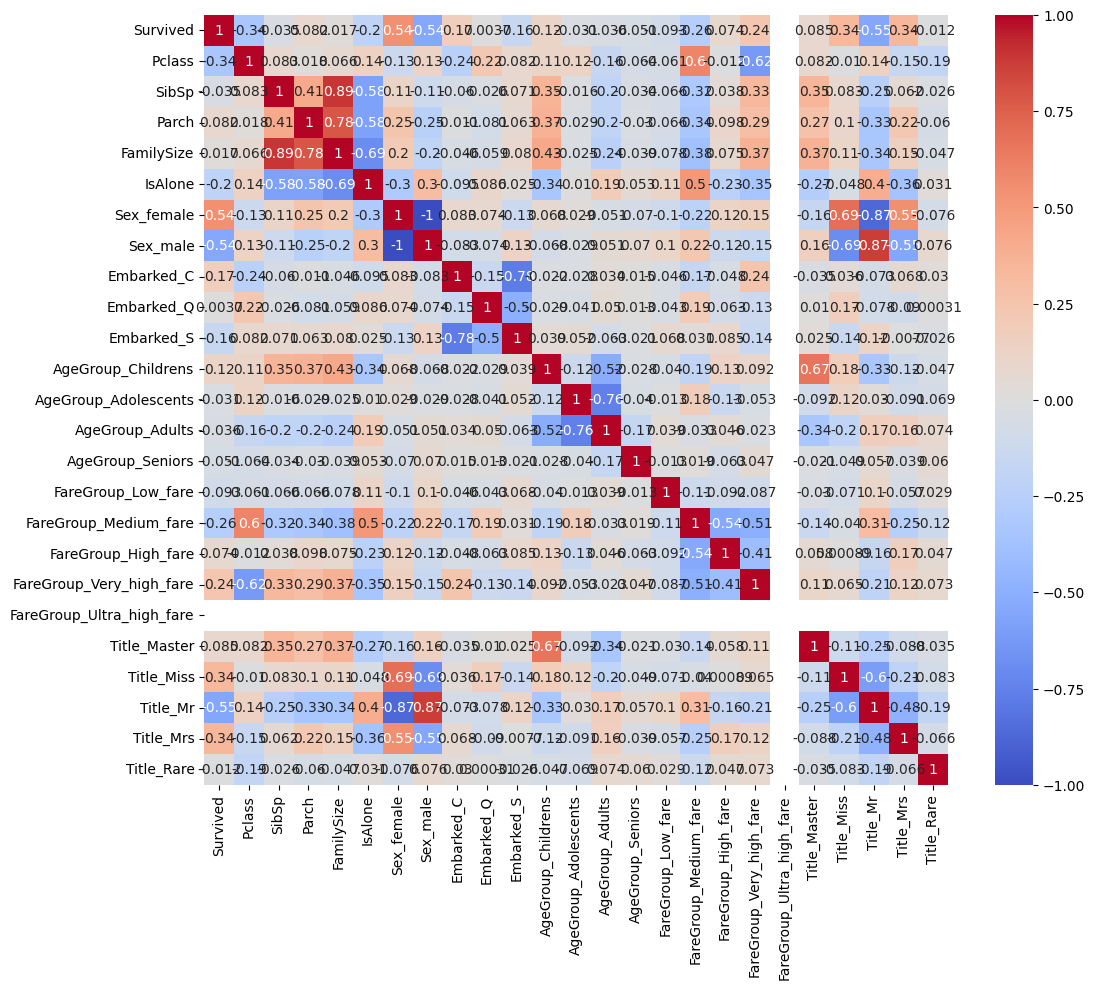

In [5]:
# Generate heatmap using seaborn
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [6]:
X = X.drop(['Survived'], axis=1)

# Define KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)

# Train the model
knn.fit(X, y)

# Predict on validation data
val_predictions = knn.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8272


In [7]:
# Predict on test data
predictions = knn.predict(X_test)

# Save predictions to csv
output_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions})
output_df.to_csv(OUTPUT_PATH, index=False)